# Email Analysis: K-Means Clustering

Clustering is an 'unsupervised learning' algorithm that has many diverse applications from computer graphics to economics. In Natural Language Processing, clustering has been used to determine authorship of the federalist papers, and analyze hundrends of thousands of documents as they are released in an instant. Clustering is particularly useful when you want to get a snapshot of a large dataset you have at hand.

### Pre-analysis Houskeeping - Imports and Defining Methods

In [1]:
%matplotlib inline

# Basic Imports
import re, os, logging, sys, random, json, xml.etree.ElementTree 
from time import time
from operator import itemgetter
from datetime import date
from datetime import timedelta
from dateutil.parser import parse
from pprint import pprint

# Sci-kit learn Machine Learning Tookit Imports
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Plotting Imports
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt, mpld3
from mpld3 import plugins
from click_info import ClickInfo
# mpld3.enable_notebook()

# Data Object Related Imports
from peewee import *
from Email import Email

def make_histogram(innerDict):
    x = np.arange(len(innerDict.keys()))
    y = innerDict.values()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(innerDict.keys(), rotation=70)
    plt.show()

db = SqliteDatabase('emails.db')
db.connect()

True

### Perpare the tools we will use

In [2]:
N_CLUSTERS = 3
reduce_dimensionality = True
color_by_party = True
k_means = KMeans(n_clusters=N_CLUSTERS, init='k-means++', max_iter=100, n_init=1, verbose=True)
vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.1, stop_words='english')
lsa = TruncatedSVD(2)

### Perpare the Data

In [3]:
emails = np.array([email for email in Email.select()])
text = np.array([email.text for email in emails])
parties = np.array([email.sender.party if email and email.sender else "" for email in emails])
vectors = vectorizer.fit_transform(text)
if reduce_dimensionality == True:
    X = lsa.fit_transform(vectors)
else:
    X = vectors

### Run K-means Clustering

In [4]:
km = k_means.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 28.34377379162939
start iteration
done sorting
end inner loop
Iteration 1, inertia 25.984420059959188
start iteration
done sorting
end inner loop
Iteration 2, inertia 25.076546105657336
start iteration
done sorting
end inner loop
Iteration 3, inertia 23.201610785608267
start iteration
done sorting
end inner loop
Iteration 4, inertia 21.628345173350453
start iteration
done sorting
end inner loop
Iteration 5, inertia 21.159105434683763
start iteration
done sorting
end inner loop
Iteration 6, inertia 21.023185724950125
start iteration
done sorting
end inner loop
Iteration 7, inertia 21.0058769997022
start iteration
done sorting
end inner loop
Iteration 8, inertia 21.003138810900573
start iteration
done sorting
end inner loop
Iteration 9, inertia 21.00191439314213
center shift 1.762941e-03 within tolerance 3.144098e-06


In [5]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
terms = vectorizer.get_feature_names()

In [6]:
if reduce_dimensionality == False:
    order_centroids = k_means_cluster_centers.argsort()[:, ::-1]
    for i in range(N_CLUSTERS):
        print([(terms[ind], k_means_cluster_centers[i][ind]) for ind in order_centroids[i, :100]])
        print("")

In [7]:
for k in range(N_CLUSTERS):
    z = vectors.toarray()[k_means_labels == k]
    wordz_tfidf = [(terms[i], z[:,i].sum()) for i in range(z.shape[1])]
    wordz_tfidf = sorted(wordz_tfidf, key=lambda x: x[1], reverse=True )
    print(wordz_tfidf[:100])
    print("")

[('senator', 81.68354778383616), ('vote', 67.61626487534294), ('message', 60.12901329847169), ('obama', 57.52809911702628), ('today', 55.83791372067094), ('political', 49.889051497995766), ('mitch', 48.85739672414709), ('support', 47.44594993948533), ('box', 45.59186927555744), ('washington', 44.043405060418955), ('future', 42.80345209449893), ('government', 42.32095331527883), ('state', 42.23593442154838), ('make', 41.58965449221981), ('new', 41.052881294920695), ('election', 40.995523166029756), ('united', 39.321101734031856), ('people', 39.06248820824899), ('states', 38.53066302841452), ('receive', 38.286905639561596), ('day', 37.107030805670135), ('just', 36.85562724607295), ('know', 36.31792073996653), ('emails', 34.91940465559045), ('team', 33.99959124888822), ('mcconnell', 33.89535026093225), ('www', 33.24288690891687), ('like', 32.54625077754243), ('time', 32.061142148291665), ('case', 30.967481078321626), ('join', 30.96195386614523), ('receiving', 30.361111047665602), ('countr

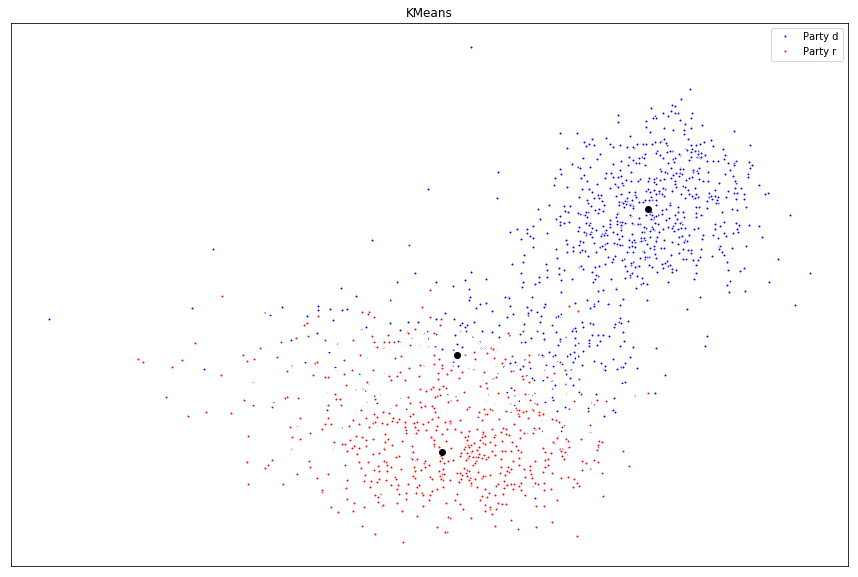

In [8]:
if reduce_dimensionality == True:
    mpld3.enable_notebook()
    fig,ax = plt.subplots(figsize=(15,10))
    
    ph = {}
    ph_counter = 0
    def add_labels(fig, boolmap, points):
            global ph_counter
            labels = []
            for email in emails[boolmap]:
                ph[ph_counter] = email.politicalnewsbot_link()
                # labels.append(str(ph_counter) + " " + email.message_id + " " + email.message_labels + " " + email.sender.party)
                labels.append(email.sender.email_address)
                ph_counter += 1

            tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10)
            plugins.connect(fig, tooltip)
            urls = [email.politicalnewsbot_link() for email in emails[boolmap]]
            # plugins.connect(fig, ClickInfo(points[0], urls))

    if color_by_party == True:
        for party, col in zip(['d', 'r'], ['blue', 'red']):
            my_members = parties == party
            points = ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', label='Party %s' % party )
            
            add_labels(fig, parties == party, points)
        
        for k in range(N_CLUSTERS):
            cluster_center = k_means_cluster_centers[k]
            centers = ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor='black', markeredgecolor='k', markersize=6)

    else:
        colors = [(random.random(), random.random(), random.random()) for x in range(N_CLUSTERS)]
        for k, col in zip(range(N_CLUSTERS), colors):
            my_members = k_means_labels == k
            cluster_center = k_means_cluster_centers[k]
            points = ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', label='Cluster %i' % k)
            centers = ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

            add_labels(fig, k_means_labels == k, points)

    ax.set_title('KMeans')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    ph_counter=0


In [9]:
mpld3.disable_notebook()

In [10]:
labels = ['CATEGORY_PROMOTIONS', 'CATEGORY_UPDATES', 'IMPORTANT', 'INBOX', 'UNREAD']
label_histogram = []
for k in range(N_CLUSTERS):
    innerDict = dict.fromkeys(labels, 0)
    for email in emails[k_means_labels == k]:
        current_labels = eval(email.message_labels)
        for label in current_labels:
            if label in innerDict:
                innerDict[label] = innerDict[label]+1
            else:
                innerDict[label] = 0

    label_histogram.append(innerDict)
label_histogram

[{'CATEGORY_PROMOTIONS': 462,
  'CATEGORY_UPDATES': 247,
  'IMPORTANT': 35,
  'INBOX': 710,
  'UNREAD': 572,
  'CATEGORY_PERSONAL': 0},
 {'CATEGORY_PROMOTIONS': 124,
  'CATEGORY_UPDATES': 548,
  'IMPORTANT': 38,
  'INBOX': 675,
  'UNREAD': 568,
  'CATEGORY_PERSONAL': 2},
 {'CATEGORY_PROMOTIONS': 275,
  'CATEGORY_UPDATES': 253,
  'IMPORTANT': 54,
  'INBOX': 536,
  'UNREAD': 396,
  'CATEGORY_PERSONAL': 7}]

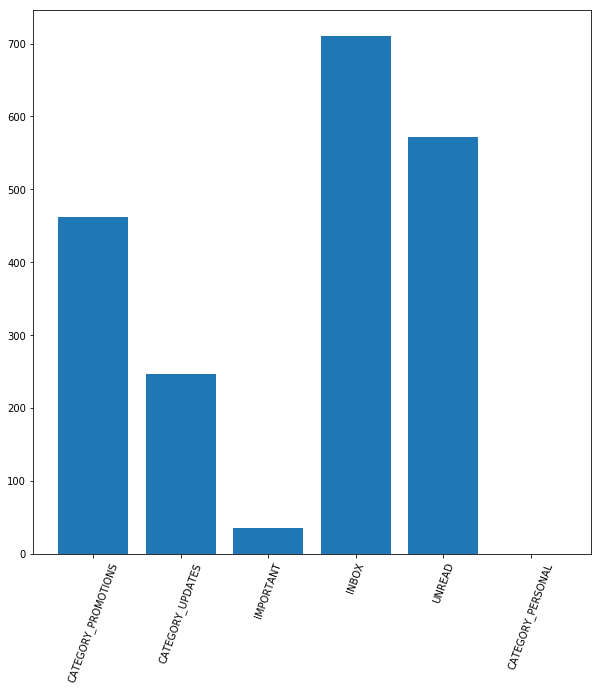

In [11]:
make_histogram(label_histogram[0])

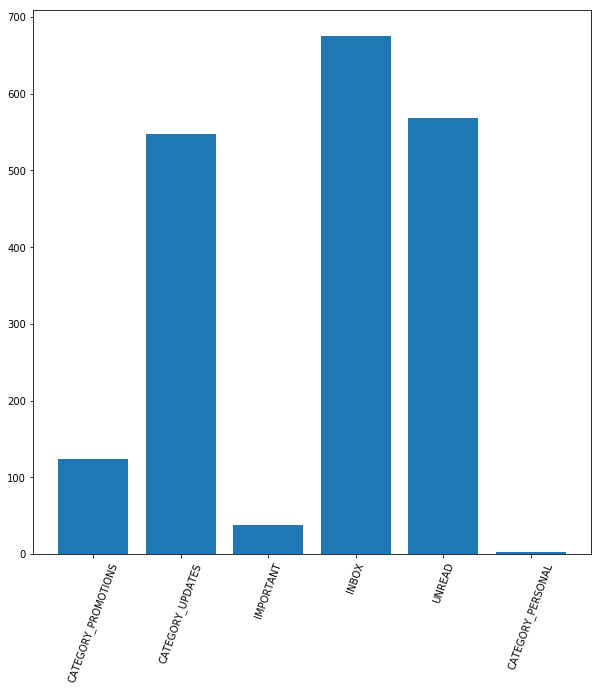

In [12]:
make_histogram(label_histogram[1])

In [13]:
print("\n".join([email.politicalnewsbot_link() for email in emails[k_means_labels == 1]]))

https://mail.google.com/mail/u/2/#inbox/1497d792b60d0400?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497d1a7219f7b6a?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497ce3c9f64f423?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497c77540230e84?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497c34da5668e11?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497c144a6198077?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497c071bfce5181?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497be451d6cd54d?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497ba52d83e14ba?authuser=politicalnewsbotnewyork@gmail.com
https://mail.google.com/mail/u/2/#inbox/1497b6543af4958d?authuser=politicalnewsbotnewyork@gmail.com
